<a href="https://colab.research.google.com/github/Artypuppet/COMP432-labs/blob/main/lab2/lab_2_excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Implementation defining a simplelayer and trying it out with different activation functions

In [1]:
import pandas as pd
import io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Dataset
data = """Day No.,Humidity  (%),Temperature (degree Celsius),Rain
1,80,20,Yes
2,20,15,No
3,70,25,Yes
4,30,24,Yes
5,55,28,No
6,68,19,Yes
7,45,21,No
8,73,17,Yes
9,44,16,No
10,56,22,No"""

# Read the string data into a pandas DataFrame using io.StringIO
df = pd.read_csv(io.StringIO(data))
# Map the 'Rain' column from 'Yes'/'No' to numerical values 1/0
df['Rain'] = df['Rain'].map({'Yes': 1, 'No': 0})
# Convert the 'Humidity' and 'Temperature' columns to a PyTorch tensor, representing the features (X)
X = torch.tensor(df[['Humidity  (%)', 'Temperature (degree Celsius)']].values, dtype=torch.float32)
# Convert the 'Rain' column to a PyTorch tensor, representing the labels (y), and add a dimension with .unsqueeze(1)
y = torch.tensor(df['Rain'].values, dtype=torch.float32).unsqueeze(1)

# Add Gaussian noise to features (relates to prob PDF section)
mean = 0 # Define the mean for the Gaussian noise
std = 0.1 # Define the standard deviation for the Gaussian noise
# Generate a tensor of random numbers from a normal distribution with the specified mean and standard deviation
noise = torch.normal(mean, std, size=X.shape)
# Add the generated noise to the original feature tensor
X_noisy = X + noise

# Split the dataset into training and testing sets
# Use train_test_split to get the indices for the training and testing data
train_idx, test_idx = train_test_split(range(len(X_noisy)), test_size=0.2, random_state=42)
# Use the indices to get the training features
X_train = X_noisy[train_idx]
# Use the indices to get the training labels
y_train = y[train_idx]
# Use the indices to get the testing features
X_test = X_noisy[test_idx]
# Use the indices to get the testing labels
y_test = y[test_idx]

### **What are Activation Functions?**
Think of an activation function as a decision-maker inside a neuron. In our brains, a neuron only "fires" (sends a signal) if the combined input signals it receives are strong enough.

In a neural network, the activation function does the same thing. It takes the output of a neuron and decides whether that signal is important enough to be passed on to the next layer. This is how the network learns to make complex, non-linear decisions. Without activation functions, a neural network is just a bunch of simple multiplications and additions, making it useless for solving anything but the simplest problems.

**Our Example:** Deciding if it will Rain
Let's imagine a neural network that predicts if it will rain based on humidity and temperature.

Humidity: 80%

Temperature: 20°C

The neuron takes these two numbers, multiplies them by some learned "weights," and adds them up. Let's say the result is 3.5. This number, 3.5, is the input to our activation function.

Now, let's see how different activation functions decide what to do with this 3.5.

### **1. ReLU (Rectified Linear Unit)**
The ReLU function is like a simple switch.

**Rule:** If the input is positive, let it pass through as is. If it's zero or negative, stop the signal completely (output 0).

**Our Example:** Our input is 3.5, which is positive. So, ReLU outputs 3.5.

**Decision:** "The signal is strong, pass it on!"

### **2. Sigmoid**
The Sigmoid function is like a probability dial. It squishes any number into a value between 0 and 1.

**Rule:** It takes any number and turns it into a decimal between 0 and 1. A number like -10 becomes close to 0, and a number like +10 becomes close to 1.

**Our Example:** Our input is 3.5. The Sigmoid function turns this into a number around 0.97.

**Decision:** "This is a very strong signal. It's almost certain (0.97) that we should predict 'Yes, it will rain!'"

### **3. Tanh (Hyperbolic Tangent)**
The Tanh function is similar to Sigmoid but outputs a value between -1 and 1.

**Rule:** It takes any number and converts it to a value between -1 and 1. Positive numbers move towards 1, and negative numbers move towards -1.

**Our Example:** Our input is 3.5. The Tanh function turns this into a number around 0.99.

**Decision:** "This is a very strong positive signal, indicating a strong 'Yes'." The negative outputs could indicate a strong 'No'.

### **4. SiLU (Sigmoid Linear Unit)**
SiLU is a newer, smoother function.

**Rule:** It's a bit more complex. It's the input number multiplied by its own Sigmoid.

**Our Example:** Our input is 3.5. SiLU multiplies 3.5 by sigmoid(3.5), which is roughly 0.97. The result is about 3.4.

**Decision:** "The signal is strong, and this function allows for a more subtle, nuanced pass-through of information." This smoothness can help deep networks train more effectively.

### **5. Leaky ReLU (Leaky Rectified Linear Unit)**
The Leaky ReLU function is like a switch that's never fully off. It lets a small amount of signal through, even if it's negative.

**Rule:** If the input is positive, let it pass through as is. If the input is zero or negative, let a small fraction of the signal pass through instead of stopping it completely.

**Our Example:** If our input is -2, ReLU would output 0. Leaky ReLU would output a small value, like -0.02 (assuming a 'leak' rate of 0.01).

**Decision:** "The signal is negative, but we'll let a little bit of information pass through anyway."

In [5]:
# ExtendedLayer is a custom PyTorch neural network module.
# It's a simple two-layer network where the activation function
# for the hidden layer can be specified during initialization.
class ExtendedLayer(nn.Module):
    # __init__ method is the constructor. It initializes the layers
    # and sets the activation function.
    def __init__(self, input_size=2, hidden_size=4, output_size=1, activation='linear'):
        super(ExtendedLayer, self).__init__()
        # fc1 is the first fully connected layer (input to hidden).
        self.fc1 = nn.Linear(input_size, hidden_size)
        # fc2 is the second fully connected layer (hidden to output).
        self.fc2 = nn.Linear(hidden_size, output_size)
        # Store the activation function as a lowercase string.
        self.activation = activation.lower()

    # forward method defines the forward pass of the network.
    # It takes an input tensor 'x', applies the first layer,
    # then the specified activation function, and finally the second layer.
    def forward(self, x):
        # Apply the first linear layer.
        x = self.fc1(x)
        # Apply the chosen activation function.
        if self.activation == 'relu':
            x = nn.ReLU()(x)
        elif self.activation == 'leaky_relu':
            x = nn.LeakyReLU()(x)
        elif self.activation == 'silu':
            x = nn.SiLU()(x)
        elif self.activation == 'sigmoid':
            x = nn.Sigmoid()(x)
        elif self.activation == 'tanh':
            x = nn.Tanh()(x)
        else:
            pass  # linear activation (no function applied)
        # Apply the second linear layer.
        x = self.fc2(x)
        return x

# This function trains and evaluates the ExtendedLayer model
# with a specified activation function.
def train_and_evaluate_ext(activation):
    # Instantiate the model with the given activation function.
    model = ExtendedLayer(activation=activation)
    # Define the optimizer (Adam) to update the model's parameters.
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # Choose the loss function.
    # BCEWithLogitsLoss is used for binary classification with a Sigmoid output.
    # MSELoss (Mean Squared Error) is used otherwise.
    criterion = nn.BCEWithLogitsLoss() if activation in ['sigmoid', 'tanh'] else nn.MSELoss()

    # Train for 200 epochs. An epoch is one full pass over the training data.
    for epoch in range(200):
        # Set the model to training mode.
        model.train()
        # Clear the gradients of all optimized tensors.
        optimizer.zero_grad()
        # Perform the forward pass to get predictions.
        outputs = model(X_train)
        # For non-sigmoid/tanh activations, apply sigmoid to the output
        # to get probabilities for the BCEWithLogitsLoss function.
        if activation not in ['sigmoid', 'tanh']:
            outputs = torch.sigmoid(outputs)
        # Calculate the loss.
        loss = criterion(outputs, y_train)
        # Perform backpropagation to calculate gradients.
        loss.backward()
        # Update model parameters.
        optimizer.step()

    # Evaluate the model's performance on the test data.
    model.eval() # Set the model to evaluation mode.
    with torch.no_grad(): # Disable gradient calculation for efficiency.
        # Get predictions on the test set.
        test_outputs = model(X_test)
        # Apply sigmoid to outputs if needed for a probability-like range.
        if activation not in ['sigmoid', 'tanh']:
            test_outputs = torch.sigmoid(test_outputs)
        # Convert probabilities to binary predictions (0 or 1).
        preds = (test_outputs > 0.5).float()
        # Calculate the accuracy by comparing predictions to true labels.
        acc = (preds == y_test).float().mean().item()

    # Perform an analysis of the eigenvalues of the first layer's weight matrix.
    # This analysis helps to understand the "shape" of the data transformation.
    W = model.fc1.weight.data
    # Calculate the Gram matrix (W.T @ W), which is a positive semi-definite matrix.
    # Its eigenvalues are related to the singular values of W, indicating the
    # variance captured along different dimensions.
    gram = W.T @ W
    # Compute the real parts of the eigenvalues of the Gram matrix.
    eigenvalues = torch.linalg.eigvals(gram).real
    print(f"Eigenvalues for {activation}: {eigenvalues.tolist()}")

    # Return the calculated accuracy.
    return acc

# Train and get accuracies for each activation function.
linear_acc = train_and_evaluate_ext('linear')
relu_acc = train_and_evaluate_ext('relu')
leaky_relu_acc = train_and_evaluate_ext('leaky_relu')
silu_acc = train_and_evaluate_ext('silu')
sigmoid_acc = train_and_evaluate_ext('sigmoid')
tanh_acc = train_and_evaluate_ext('tanh')

# Print the final validation accuracies.
print(f"Linear Validation Accuracy: {linear_acc}")
print(f"ReLU Validation Accuracy: {relu_acc}")
print(f"Leaky ReLU Validation Accuracy: {leaky_relu_acc}")
print(f"SiLU Validation Accuracy: {silu_acc}")
print(f"Sigmoid Validation Accuracy: {sigmoid_acc}")
print(f"Tanh Validation Accuracy: {tanh_acc}")

Eigenvalues for linear: [0.7673684358596802, 1.1856743097305298]
Eigenvalues for relu: [0.6312069892883301, 2.3299219608306885]
Eigenvalues for leaky_relu: [0.19966983795166016, 3.994230270385742]
Eigenvalues for silu: [0.09868526458740234, 2.0092015266418457]
Eigenvalues for sigmoid: [0.7727987766265869, 2.734130859375]
Eigenvalues for tanh: [0.9074492454528809, 0.5849487781524658]
Linear Validation Accuracy: 1.0
ReLU Validation Accuracy: 0.5
Leaky ReLU Validation Accuracy: 1.0
SiLU Validation Accuracy: 0.0
Sigmoid Validation Accuracy: 0.5
Tanh Validation Accuracy: 0.0


# **Probabilistic Implementations**

## a. Expectations and Variance Computation

**Expectation** is just another word for the average. It's the number you would "expect" to get if you took the average of all the data points.

Imagine you have a class of 10 students and you want to know the average height. You measure each student's height, add them all up, and divide by 10. That final number is the average height, or the expectation of the height for a student in that class. If you were to pick a student at random, you'd "expect" their height to be close to this average.

**Variance** tells you how spread out the data is from the average.  A small variance means the data points are all close together, while a large variance means they are very spread out.

*   **Low Variance:** If all 10 students are almost exactly the same height (e.g., they are all between 5'5" and 5'7"), their height has a low variance.
*   **High Variance:** If some students are very short (e.g., 4'0") and others are very tall (e.g., 6'8"), their height has a high variance.

Variance is useful because it measures the variability or risk. In a dataset, high variance means the values are unpredictable and can vary a lot, which is crucial information for a machine learning model.

In [ ]:
# Expectation E(X) for features (discrete approx)
# Calculate the mean (expectation) of the 'Humidity' feature.
exp_hum = torch.mean(X[:, 0]).item()
# Calculate the mean (expectation) of the 'Temperature' feature.
exp_temp = torch.mean(X[:, 1]).item()
print(f"E(Humidity): {exp_hum}, E(Temperature): {exp_temp}")

# Variance Var(X)
# Calculate the variance of the 'Humidity' feature.
var_hum = torch.var(X[:, 0]).item()
# Calculate the variance of the 'Temperature' feature.
var_temp = torch.var(X[:, 1]).item()
print(f"Var(Humidity): {var_hum}, Var(Temperature): {var_temp}")

# Covariance Cov(Humidity, Temperature)
# Calculate the covariance matrix for the features.
# The .T transposes the tensor so that each column represents a feature, which is the required format for torch.cov.
cov_matrix = torch.cov(X.T)
# Print the covariance matrix as a list.
print("Covariance matrix:\n", cov_matrix.tolist())

E(Humidity): 54.099998474121094, E(Temperature): 20.700000762939453
Var(Humidity): 378.54443359375, Var(Temperature): 17.344444274902344
Covariance matrix:
 [[378.54449462890625, 13.922221183776855], [13.922221183776855, 17.344446182250977]]


## b. Conditional Distributions and Independence Check

**Conditional Distributions**:
A conditional distribution looks at a specific group within your data to find the average. It helps you answer questions like, "What's the probability of something happening, GIVEN that something else is true?"

Imagine you want to know the probability of rain. A simple average might be 50%. But if you look at a specific condition—"What's the probability of rain GIVEN that the humidity is high?"—you're likely to get a much higher number, say 90%. This gives you a more accurate and useful prediction.

**Independence Check**:
Independence is a concept in probability where knowing the outcome of one event tells you nothing about the outcome of another. You can check for approximate independence by looking at the covariance between two variables. If the covariance is close to zero, it suggests the two events are independent.

*   **Independent Events:** The amount of rain you get this month is likely independent of the stock market's performance. Knowing that it rained a lot doesn't help you predict if the stock market went up or down. Their covariance would be close to zero.
*   **Dependent Events:** The amount of rain you get is dependent on the humidity. When humidity is high, the probability of rain is also high. Their covariance would be a large positive number, indicating they are linked.

In [ ]:
# Conditional expectation E(Rain|Humidity > mean)
# Create a boolean mask to select data points where humidity is greater than the calculated mean.
high_hum_mask = X[:, 0] > exp_hum
# Calculate the conditional expectation (mean) of 'Rain' for only those data points
# that meet the high humidity condition defined by the mask.
cond_exp_rain_high_hum = torch.mean(y[high_hum_mask]).item()
print(f"E(Rain|Humidity > mean): {cond_exp_rain_high_hum}")

# Check approximate independence (cov ~0?)
# Calculate the covariance between 'Humidity' (X[:, 0]) and 'Rain' (y).
# torch.cat combines the two tensors, and .T ensures they are treated as rows for the covariance calculation.
cov_hum_rain = torch.cov(torch.cat((X[:, 0].unsqueeze(0), y.T), dim=0))[0, 1].item()
# A covariance close to 0 suggests the variables are approximately independent.
print(f"Cov(Humidity, Rain) ~0 for independence: {cov_hum_rain}")

E(Rain|Humidity > mean): 0.6666666865348816
Cov(Humidity, Rain) ~0 for independence: 5.611111164093018


## c. Bayes Rule Approximation

Bayes' Rule is a way to update your beliefs about an event when you get new evidence. It helps you figure out the probability of something happening based on what you already knew and what you've just observed.

Think of it like being a detective. Your initial guess is the prior. The new clue you find is the evidence. Bayes' Rule helps you use that clue to make a much better, more informed guess (the posterior).

In [ ]:
# Priors
# Calculate the prior probability of rain (P(Rain)), which is the overall proportion of rainy days in the dataset.
p_rain = torch.mean(y).item()
# Calculate the prior probability of high humidity (P(Humidity high)), which is the proportion of days with humidity above the average.
p_hum_high = (X[:, 0] > exp_hum).float().mean().item()

# Likelihood P(Rain|Humidity high)
# Calculate the likelihood: the probability of rain given that humidity is high.
# This is the same as the conditional expectation calculated earlier.
p_rain_given_high_hum = torch.mean(y[high_hum_mask]).item()

# Posterior
# Calculate the posterior probability P(High Humidity|Rain) using Bayes' Theorem.
# The formula is: P(A|B) = [P(B|A) * P(A)] / P(B)
# Here, A = 'High Humidity' and B = 'Rain'.
p_high_hum_given_rain = (p_rain_given_high_hum * p_hum_high) / p_rain
print(f"P(High Humidity|Rain) via Bayes: {p_high_hum_given_rain}")

P(High Humidity|Rain) via Bayes: 0.8000000556310027


## d. Sampling from Distributions (Bernoulli, Poisson, Gaussian)

**Bernoulli Distribution**: This distribution models a simple event with two outcomes, like a coin flip. You specify the probability of one outcome (e.g., heads), and then you can sample to get a series of heads or tails results. It's used for binary classification outcomes.

**Poisson Distribution**: This distribution is used for counting how many times an event occurs in a fixed period, like the number of phone calls to a call center in an hour. You provide the average rate of occurrence, and the distribution gives you a likely count. It's used for modeling rare events.

**Gaussian (Normal) Distribution**: Also known as the "bell curve," this is a continuous distribution where data points cluster around an average value. You define the mean and spread (variance), and you can sample to generate new, realistic data points that follow this pattern. It's widely used for modeling natural phenomena like height or temperature.

In [ ]:
# Bernoulli for simulated labels
# Define the probability for the Bernoulli distribution. This can be seen as the
# overall probability of 'Rain' from the original dataset.
bern_p = 0.5
# Create a Bernoulli distribution object with the defined probability.
# .sample((10, 1)) draws 10 samples (e.g., simulating 10 days) from this distribution,
# with each sample being a binary outcome (1 for success/rain, 0 for failure/no rain).
bern_samples = torch.distributions.Bernoulli(probs=bern_p).sample((10, 1))
print("Bernoulli samples (sim rain):\n", bern_samples.tolist())

# Poisson for simulated event counts (e.g., rain days)
# Define the rate parameter (lambda) for the Poisson distribution, which represents
# the average number of events (e.g., rainy days) in a fixed interval.
pois_lambda = 2.0
# Create a Poisson distribution and draw 10 samples. Each sample is a non-negative
# integer representing the number of events.
pois_samples = torch.distributions.Poisson(rate=pois_lambda).sample((10,))
print("Poisson samples:\n", pois_samples.tolist())

# Gaussian for noisy features
# Define the mean vector for the Gaussian (Normal) distribution. This vector
# contains the mean of each feature ('Humidity' and 'Temperature').
gauss_mean = torch.tensor([exp_hum, exp_temp])
# Define the covariance matrix for the distribution, which was calculated earlier.
# This matrix captures the variance of each feature and the covariance between them.
gauss_cov = cov_matrix
# Create a MultivariateNormal distribution object using the mean vector and covariance matrix.
gauss_dist = torch.distributions.MultivariateNormal(gauss_mean, gauss_cov)
# Draw 5 samples from this multivariate Gaussian distribution. Each sample is a
# vector with two components, simulating a pair of 'Humidity' and 'Temperature' values.
gauss_samples = gauss_dist.sample((5,))
print("Gaussian samples:\n", gauss_samples.tolist())

Bernoulli samples (sim rain):
 [[0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0]]
Poisson samples:
 [1.0, 3.0, 1.0, 1.0, 2.0, 2.0, 0.0, 3.0, 3.0, 1.0]
Gaussian samples:
 [[50.76548385620117, 25.178524017333984], [39.170654296875, 18.41327476501465], [50.60792541503906, 22.319992065429688], [72.70157623291016, 27.481904983520508], [83.90538787841797, 25.1619930267334]]


## e. Jensen's Inequality Demo

Jensen's Inequality states that for a convex function like f(x)=x^2, the average of the function's output is always greater than or equal to the function of the average input.

Think of a group of people's incomes. If you calculate the average income and then square it, you get one number. But if you square each person's income first and then find the average of those squared values, that number will always be larger. Jensen's Inequality shows that for a convex function like squaring, the average of the outputs is always greater than or equal to the output of the average.

In [ ]:
# Convex function f(x) = x^2, apply to humidity
# Select the humidity values from the feature tensor X.
hum_vals = X[:, 0]
# Calculate the expectation of the function: E(f(X)).
# This involves squaring each humidity value first, and then taking the mean of the results.
exp_f = torch.mean(hum_vals ** 2).item()
# Calculate the function of the expectation: f(E(X)).
# This involves taking the mean of the humidity values first, and then squaring the result.
f_exp = (torch.mean(hum_vals) ** 2).item()
# Print the results to demonstrate Jensen's Inequality, which states that E[f(X)] >= f[E(X)] for a convex function f.
print(f"Jensen: E(f(X))={exp_f} >= f(E(X))={f_exp}")

Jensen: E(f(X))=3267.5 >= f(E(X))=2926.809814453125


#**Linear Algebra Implementations**

## a. Trace, Determinant, and Inverse

**Trace**:
The trace of a matrix is the sum of its diagonal elements. In the context of a covariance matrix, the trace represents the total variance of all the features combined, giving a single number that summarizes the overall spread of your data.

**Determinant**:
The determinant of a matrix tells you if the matrix is invertible and how much the space is "scaled" by the transformation the matrix represents. For a covariance matrix, a positive determinant confirms that the matrix is valid and that the features are not perfectly redundant. A determinant of zero would mean at least one feature is a perfect linear combination of the others.

**Inverse**:
The inverse of a matrix, if it exists, is a second matrix that "undoes" the transformation of the first. In statistics, the inverse of the covariance matrix (called the precision matrix) is used to calculate things like the probability density of a multivariate Gaussian distribution.

In [ ]:
# Cov matrix from prob section
# Calculate and print the trace of the covariance matrix.
# The trace is the sum of the diagonal elements, which represents the total variance of the features.
print(f"Trace of cov: {torch.trace(cov_matrix).item()}")

# Determinant (for PSD check, |cov| >0)
# Calculate the determinant of the covariance matrix.
# A positive determinant is a condition for the matrix to be positive semi-definite (PSD),
# which is required for it to be a valid covariance matrix.
det_cov = torch.det(cov_matrix).item()
print(f"Det of cov: {det_cov}")

# Inverse (if invertible)
# Check if the determinant is non-zero. A non-zero determinant means the matrix is invertible.
if det_cov != 0:
    # Calculate and print the inverse of the covariance matrix.
    # The inverse is used in various statistical and machine learning applications,
    # such as in the formula for the multivariate Gaussian probability density function.
    inv_cov = torch.inverse(cov_matrix)
    print("Inverse cov:\n", inv_cov.tolist())

Trace of cov: 395.8889465332031
Det of cov: 6371.81640625
Inverse cov:
 [[0.0027220568154007196, -0.0021849689073860645], [-0.002184969140216708, 0.05940919741988182]]


## b. Norms and Rank

**Norms** measure the "length" or "magnitude" of a vector. The L2 norm is the standard Euclidean distance from the origin, calculated as the square root of the sum of the squared components. The L1 norm is the sum of the absolute values of the components, often called the Manhattan distance.

The **rank** of a matrix tells you the number of its linearly independent columns or rows. A matrix has full rank if its rank is equal to the smaller of its number of rows or columns. It's a key concept in linear algebra, indicating if the data has any redundant features.

In [ ]:
# L2 norm of first feature vector
# Calculate the L2 norm (Euclidean distance from the origin) of the first data sample.
# This represents the length or magnitude of the vector containing the first day's humidity and temperature.
l2_norm = torch.norm(X[0]).item()
print(f"L2 norm of first sample: {l2_norm}")

# L1 norm
# Calculate the L1 norm (Manhattan distance) of the same data sample.
# The 'p=1' argument specifies the L1 norm. It's the sum of the absolute values of the vector's components.
l1_norm = torch.norm(X[0], p=1).item()
print(f"L1 norm: {l1_norm}")

# Matrix rank (full rank=2 for 2 features)
# Calculate the rank of the data matrix. The rank indicates the number of linearly independent
# columns (or rows). A full rank means no feature is a perfect linear combination of the others.
# The Gram matrix (X.T @ X) is often used for numerical stability when calculating rank.
rank_X = torch.linalg.matrix_rank(X.T @ X).item()
print(f"Rank of data matrix: {rank_X}")

L2 norm of first sample: 82.46211242675781
L1 norm: 100.0
Rank of data matrix: 2


## c. Eigenvalues/Eigenvectors and Quadratic Form

**Eigenvalues & Eigenvectors**:
Imagine you have a rubber sheet you're stretching. Eigenvectors are the specific lines you've drawn on the sheet that don't change their direction when you stretch it, even though their length might change. The eigenvalue is the number that tells you how much that specific line got stretched. In data, they show the directions of greatest variance.

**Quadratic Form**:
A quadratic form is a calculation that tells you the shape of a surface. Think of it as a blueprint for an ellipse or an ellipsoid. For example, the equation **ax^2 + by^2 = 1** is a quadratic form that draws an ellipse. In machine learning, this calculation is used to define the shape of a bell curve in multiple dimensions, which is crucial for probability distributions.

In [ ]:
# Eigen decomp of cov (symmetric, relates to PSD)
# Compute the eigenvalues and eigenvectors of the covariance matrix.
# The `eigh` function is used for symmetric matrices, which covariance matrices are.
# Eigenvalues must be non-negative for a valid covariance matrix (Positive Semi-Definite).
eigvals, eigvecs = torch.linalg.eigh(cov_matrix)
print("Eigenvalues:\n", eigvals.tolist())
print("Eigenvectors:\n", eigvecs.tolist())

# Quadratic form x^T A x (A=cov, x=first sample)
# Calculate the quadratic form using the first data sample vector (X[0]) and the covariance matrix.
# This operation (x^T * A * x) results in a scalar and is used in many machine learning
# contexts, such as the exponent of a multivariate Gaussian probability density function.
quad_form = (X[0].T @ cov_matrix @ X[0]).item()
print(f"Quadratic form: {quad_form}")

Eigenvalues:
 [16.808618545532227, 379.080322265625]
Eigenvectors:
 [[0.038458775728940964, -0.9992601275444031], [-0.9992601275444031, -0.038458775728940964]]
Quadratic form: 2474173.5


/tmp/ipython-input-3566382883.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  quad_form = (X[0].T @ cov_matrix @ X[0]).item()


## d. Matrix Transpose and Hadamard Product

The **transpose of a matrix** simply flips it over its diagonal, turning its rows into columns and its columns into rows. It's a fundamental operation in linear algebra, often used to align dimensions for matrix multiplication.

The **Hadamard product** (or element-wise product) is a multiplication where two matrices of the same size are multiplied element by element. It's a straightforward operation, unlike standard matrix multiplication, as it doesn't involve rows and columns interactions.

In [ ]:
# Transpose of X
# Transpose the feature tensor X. The rows become columns and the columns become rows.
# This operation is often needed for matrix multiplication (e.g., X.T @ X) or for
# functions like torch.cov that expect features in rows.
X_transpose = X.T
print("X transpose shape:", X_transpose.shape)

# Hadamard product (element-wise) of first two rows
# Perform an element-wise multiplication (Hadamard product) of the first two rows (samples) of X.
# This means the first element of row 0 is multiplied by the first element of row 1, and so on.
hadamard_prod = X[0] * X[1]
print("Hadamard product of rows 0 and 1:\n", hadamard_prod.tolist())

X transpose shape: torch.Size([2, 10])
Hadamard product of rows 0 and 1:
 [1600.0, 300.0]


## e. Orthogonal Matrix Construction

In [ ]:
# Generate a random matrix (e.g., from data covariance or weights)
# Create a new 2x2 matrix by adding random noise to the covariance matrix.
# This serves as a general matrix to demonstrate QR decomposition.
random_mat = cov_matrix + torch.randn(2, 2)

# QR decomposition to get orthogonal Q
# Perform QR decomposition on the random matrix.
# This decomposes the matrix into an orthogonal matrix Q and an upper triangular matrix R.
Q, R = torch.linalg.qr(random_mat)
print("Orthogonal Matrix Q:\n", Q.tolist())

# Verify orthogonality: Q^T Q should be identity
# Multiply the transpose of Q by Q to verify its orthogonality.
# For an orthogonal matrix, this product should result in the identity matrix.
Q_t_Q = Q.T @ Q
print("Q^T Q (should be identity):\n", Q_t_Q.tolist())

Orthogonal Matrix Q:
 [[-0.9993083477020264, -0.03718753904104233], [-0.03718753904104233, 0.9993082880973816]]
Q^T Q (should be identity):
 [[1.0000001192092896, 3.725290298461914e-09], [3.725290298461914e-09, 0.9999999403953552]]


#**Task: Build, Train, and Evaluate a Three-Layer Neural Network**

Your task is to complete the code below to build and train a neural network that predicts rain. You will define a training function, use both the ReLU and SiLU activation functions, and plot the final accuracy to compare their performance.

In [6]:
# Importing Libraries
import pandas as pd
import io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset Preparation (Provided for context)
data = """Day No.,Humidity  (%),Temperature (degree Celsius),Rain
1,80,20,Yes
2,20,15,No
3,70,25,Yes
4,30,24,Yes
5,55,28,No
6,68,19,Yes
7,45,21,No
8,73,17,Yes
9,44,16,No
10,56,22,No"""

df = pd.read_csv(io.StringIO(data))
df['Rain'] = df['Rain'].map({'Yes': 1, 'No': 0})
X = torch.tensor(df[['Humidity  (%)', 'Temperature (degree Celsius)']].values, dtype=torch.float32)
y = torch.tensor(df['Rain'].values, dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# ----- Section 1: Define the Three-Layer Neural Network -----
class ThreeLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation):
        super(ThreeLayerNet, self).__init__()
        # TODO: Define the three linear layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = activation.lower()

    def forward(self, x):
        # TODO: Pass the input through the first layer
        layers = [self.fc1, self.fc2, self.fc3]

        for layer in layers:
          x = layer(x)
          # TODO: Implement the activation function logic here.
          if self.activation == 'relu':
              # TODO: Apply ReLU
              x = nn.ReLU()(x)
          elif self.activation == 'silu':
              x = nn.SiLU()(x)
          else:
              pass

        # TODO: Pass through the second and third layers

        return x

In [10]:
# ----- Section 2: Training and Evaluation Function -----
def train_and_evaluate(activation):
    """Trains and evaluates a model with the specified activation function."""
    model = ThreeLayerNet(input_size=2, hidden_size1=8, hidden_size2=4, output_size=1, activation=activation)

    # TODO: Define the optimizer (e.g., Adam) for the model parameters with a learning rate of 0.01.
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # TODO: Define the loss function (BCEWithLogitsLoss is suitable for binary classification).
    criterion = nn.BCEWithLogitsLoss()

    # Lists to store metrics for plotting
    train_losses = []
    eval_accuracies = []

    # Training Loop
    for epoch in range(200):
        model.train()

        # TODO: Zero the gradients.
        optimizer.zero_grad()


        # Forward pass
        outputs = model(X_train)

        # TODO: Calculate the loss.
        output_prob = torch.sigmoid(outputs)
        loss = criterion(output_prob, y_train)

        # TODO: Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluation Phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_preds = (torch.sigmoid(test_outputs) > 0.5).float()
            accuracy = (test_preds == y_test).float().mean().item()
            eval_accuracies.append(accuracy)

    return eval_accuracies, train_losses

In [11]:
# ----- Section 3: Run the Experiment and Plot Results -----

# Run the training and evaluation for both activation functions
relu_accuracies, relu_losses = train_and_evaluate('relu')
silu_accuracies, silu_losses = train_and_evaluate('silu')

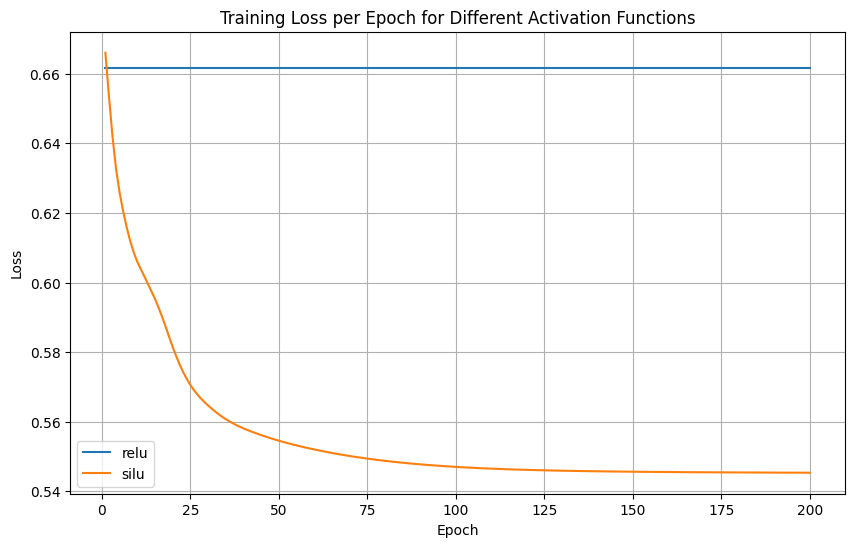

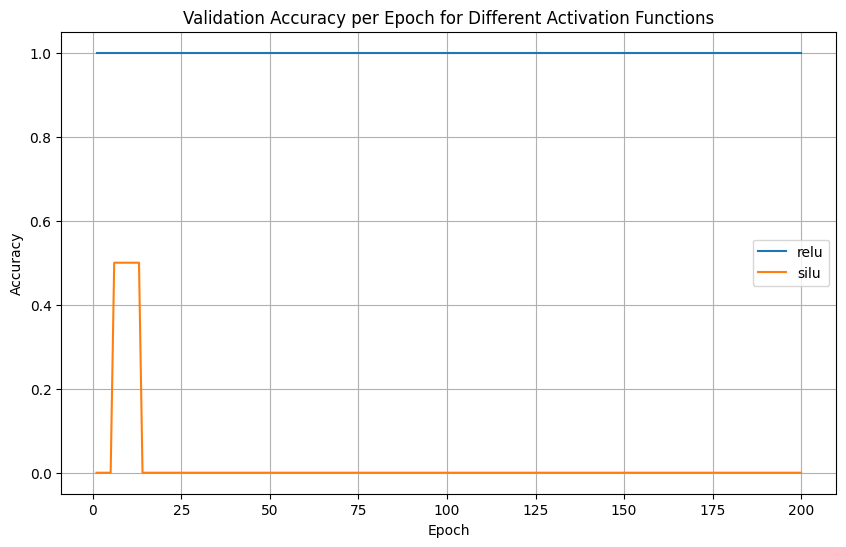

In [12]:
# Plotting the training loss curves
plt.figure(figsize=(10, 6))

# TODO: Plot the ReLU training loss.
plt.plot(range(1, 201), relu_losses, label='relu')

# TODO: Plot the SiLU training loss.
plt.plot(range(1, 201), silu_losses, label='silu')

plt.title('Training Loss per Epoch for Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the validation accuracy curves
plt.figure(figsize=(10, 6))

# TODO: Plot the ReLU validation accuracy.
plt.plot(range(1, 201), relu_accuracies, label='relu')

# TODO: Plot the SiLU validation accuracy.
plt.plot(range(1, 201), silu_accuracies, label='silu')


plt.title('Validation Accuracy per Epoch for Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()